In [33]:
import os
import json
import requests
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# read the data
data = pd.read_csv("../results/inf_outf.csv", index_col=0)
# convert index to datetime
data.index = pd.to_datetime(data.index)

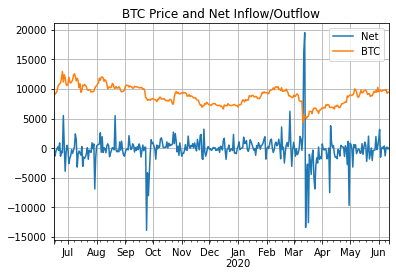

In [3]:
# let's look at inflow/outflow and price
data.drop(columns=["volume", "inflow", "outflow"]).plot()
plt.title("BTC Price and Net Inflow/Outflow")
plt.legend(["Net", "BTC"])
plt.grid(True)

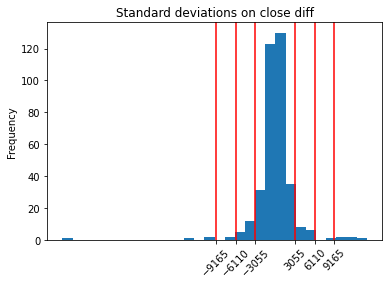

In [4]:
# calculate the daily change
diff = data.net.diff()
# the standard deviation in daily change
s = diff.std()

# let's observe the variances in change in net in/out
diff.plot.hist(bins=30)
for i in range(3):
    plt.axvline(s*(1+i), color='r')
    plt.axvline(s*(-(i+1)), color='r')
    
plt.title("Standard deviations on close diff")
plt.xticks([s*(-(1+i)) for i in reversed(range(3))] + [s*(1+i) for i in range(3)], rotation=45)
#plt.xlim(-20000, 20000)
plt.show()

In [5]:
sigma = 3*s      # what we consider anomolous inflow/outflow

# calculating days of large than average net flow
data["net_diff"] = data.net.diff().fillna(0)
data["anom"] = np.where(abs(data.net_diff) > sigma, 1, 0)

print("{:.3f}".format(100*(1-sum(data.anom)/len(data))) + "% non-anomolous days")

97.521% non-anomolous days


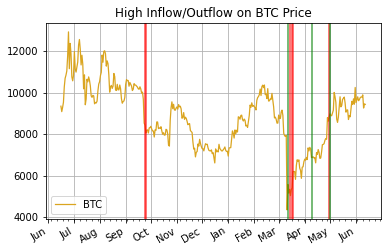

In [6]:
months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter('%b')
weeks = mdates.WeekdayLocator()

fig, ax = plt.subplots()

ax.plot(data.close, color="goldenrod", lw=1.25)

# add the high inflow/outflow days
for i in data.index[data.anom==1]:
    if data.loc[i].net > 0:
        ax.axvline(i, color='g', alpha=0.7)
    else:
        ax.axvline(i, color='r', alpha=0.7)
    
# set the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(weeks)

# add grid
ax.grid(True)
ax.set_title("High Inflow/Outflow on BTC Price")
# format ticks
fig.autofmt_xdate()
ax.legend(["BTC"])
plt.show()

### Now, on to the Activity Data

In [59]:
def start_end_time():
    endTime = datetime.datetime.now()
    startTime = endTime - datetime.timedelta(30)

    endTime = str(int(endTime.timestamp()))
    startTime = str(int(startTime.timestamp()))
    return startTime, endTime

def get_response(url, headers=None, queryString=None):
    "Get the REST response from the specified URL"
    if not headers:
        headers = {'x-api-key': api_key}
    if queryString:
        response = requests.request("GET", url, headers=headers, params=queryString)
    else:
        response = requests.request("GET", url, headers=headers)
    response = json.loads(response.text)
    try:
        if response["title"] == "OK":
            return response["payload"]
    except Exception:
        print(response)
        return None
    
def reindex(data, index):
    """ Returns the DataFrame calculated w/ inflow & outflow
    :type data: DataFrame
    :type index: List[int]
    :rtype: DataFrame
    """
    d = np.digitize(data.timestamp.values, index)
    g = data[["inflow", "outflow"]].groupby(d).sum()
    g = g.reindex(range(24*30), fill_value=0)
    g.index = index
    return g

def inflow_outflow(data: dict):
    "Returns the inflow and outflow of the payload"
    # get the column names
    columns = data["metadata"]["columns"]
    # load the data, dropping timestampNano
    ad_hist = pd.DataFrame(data["data"], columns=columns).drop("timestampNanoseconds", axis=1)
    # change dtype of appropriate columns to Int
    ad_hist[["blockNumber", "timestamp", "value"]] = ad_hist[["blockNumber", "timestamp", "value"]].apply(pd.to_numeric)
    # sort by blockNum desc
    ad_hist = ad_hist.sort_values("timestamp").reset_index(drop=True)
    # calculate inflow and outflow
    ad_hist["diff"] = ad_hist["value"].diff()
    ad_hist["inflow"] = np.where(ad_hist["diff"] > 0, ad_hist["diff"], 0)
    ad_hist["outflow"] = np.where(ad_hist["diff"] < 0, abs(ad_hist["diff"]), 0)
    # return the result
    return ad_hist
    
def daily_inflow_outflow(address, headers, querystring):
    url = "https://web3api.io/api/v2/addresses/" + address + "/account-balances/historical"
    try:
        payload = get_response(url=url, headers=headers, queryString=querystring)
    except Exception:
        return None
    if len(payload["data"]) > 1:   # if there is activity in the period
        # calculate inflow / outflow
        data = inflow_outflow(payload)
        # get in the format to merge with master inflow/outflow data
        g = reindex(data, index)
        return g


In [86]:
startTime, endTime = start_end_time()
index = [10**3*(int(startTime) + i*60**2) for i in range(24*30)]

querystring = {"startDate": startTime,
               "endDate": endTime
              }

headers = {
    'x-amberdata-blockchain-id': "bitcoin-mainnet",
    'x-api-key': os.getenv("AMBERDATA_API_KEY")
}

df = pd.read_csv("../input/addresses_all.csv")
# check if we are running the full calculation
addresses = df.Address.values

In [88]:
activ = []
i = 0

while len(activ) < 30:
    url = "https://web3api.io/api/v2/addresses/" + addresses[i] + "/account-balances/historical"
    try:
        payload = get_response(url=url, headers=headers, queryString=querystring)
    except Exception:
        pass
    i += 1
    if len(payload["data"]) > 1:   # if there is activity in the period
        # calculate inflow / outflow
        data = inflow_outflow(payload)
        # get in the format to merge with master inflow/outflow data
        g = reindex(data, index)
        g.index = [datetime.datetime.fromtimestamp(i//10**3) for i in g.index.values]
        activ.append(g)
    

In [107]:
data.shape

(5, 720)

Text(0.5, 1.0, 'BitMEX Outflows timing-10 Addresses')

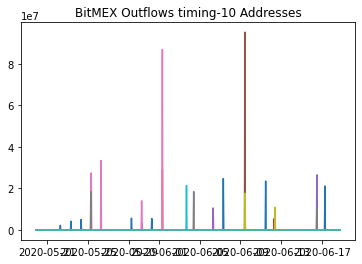

In [139]:
N = 30
data = [i.outflow for i in activ[:N]]

for i in range(len(data)):
    plt.plot(data[i])
    
plt.title(f"BitMEX Outflows timing-{N} Addresses")

In [127]:
combined = pd.DataFrame(data).T
combined.columns = [str(i) for i in range(N)]
combined.head()

,0,1,2,3,4,5,6,7,8,9
2020-05-19 20:28:05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-19 21:28:05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-19 22:28:05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-19 23:28:05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-20 00:28:05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Looking for Whales

In [129]:
with open("../results/tot_activity.json", "r") as f:
    inp = f.read()
    
act = json.loads(inp)

In [137]:
def format_activity(d):
    d = json.loads(d)
    df = pd.DataFrame(d).reset_index()
    time = pd.to_numeric(df["index"])
    df.index = [datetime.datetime.fromtimestamp(t//10**3) for t in time]
    df = df.drop(["index"], axis=1)
    return df

In [138]:
all_activity = {key: format_activity(val) for key, val in act.items() if val}

In [146]:
infs, outfs = [0]*len(all_activity.keys()), [0]*len(all_activity.keys())
i = 0

for key, val in all_activity.items():
    infs[i] = val.inflow.sum()
    outfs[i] = val.outflow.sum()
    i += 1

ValueError: 2 columns passed, passed data had 184357 columns

In [148]:
tot_flows = pd.DataFrame({"inf tot":infs, "outf tot":outfs}, index=all_activity.keys())

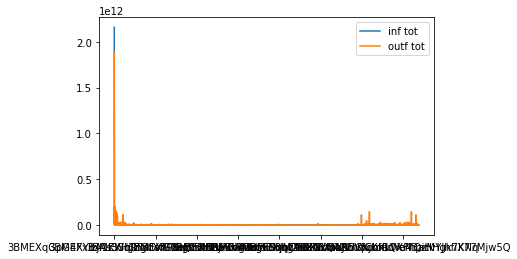

In [153]:
tot_flows.sort_values(by=["inf tot"], ascending=False).plot()

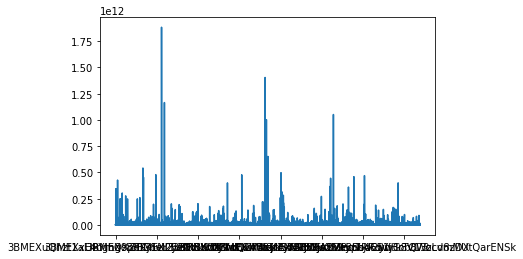

In [152]:
tot_flows["outf tot"].plot()

Look at BitMEX vs. BMEX